# Credits

This notebook is taken from:

https://github.com/fonnesbeck/bayes_course_july2020/blob/master/notebooks/Section1_3-Model_Comparison.ipynb 

* Minor edits by G. Corani

# Model comparison 

To demonstrate the use of model comparison criteria, we consider again the radon model. 

Below, we fit a **pooled model**, which assumes a single fixed effect across all counties, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_context('notebook')

RANDOM_SEED = 42

The data include the observed radon levels and associated covariates for 85 counties in Minnesota.

In [2]:
radon_data = pd.read_csv('data/radon.csv', index_col=0)
radon_data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


### Pooled model

In [3]:
#slightly different parameterization from what we used so far.
#however our focus is on model selection.
from pymc import Model, sample, Normal, HalfCauchy, Uniform

floor = radon_data.floor.values
log_radon = radon_data.log_radon.values

with Model() as pooled_model:
    
    β = Normal('β', 0, sigma=1e5, shape=2)
    σ = HalfCauchy('σ', 5)
    
    θ = β[0] + β[1]*floor
    
    y = Normal('y', θ, sigma=σ, observed=log_radon)
    
    trace_p = sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


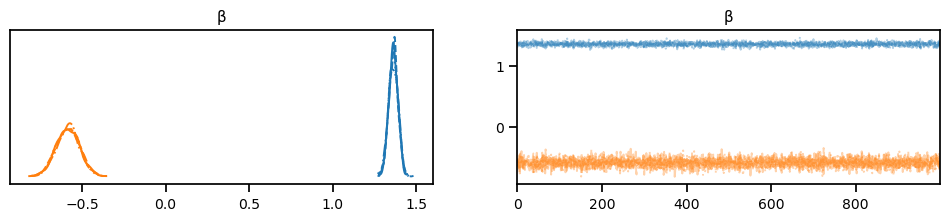

In [4]:
az.plot_trace(trace_p, var_names=['β']);

### Unpooled model

In [5]:
counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county.replace(dict(zip(counties, np.arange(n_counties)))).values

with Model() as unpooled_model:
    
    β0 = Normal('β0', 0, sigma=10, shape=n_counties)
    β1 = Normal('β1', 0, sigma=10)
    σ = HalfCauchy('σ', 5)
    
    θ = β0[county] + β1*floor
    
    y = Normal('y', θ, sigma=σ, observed=log_radon)
    
    trace_u = sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


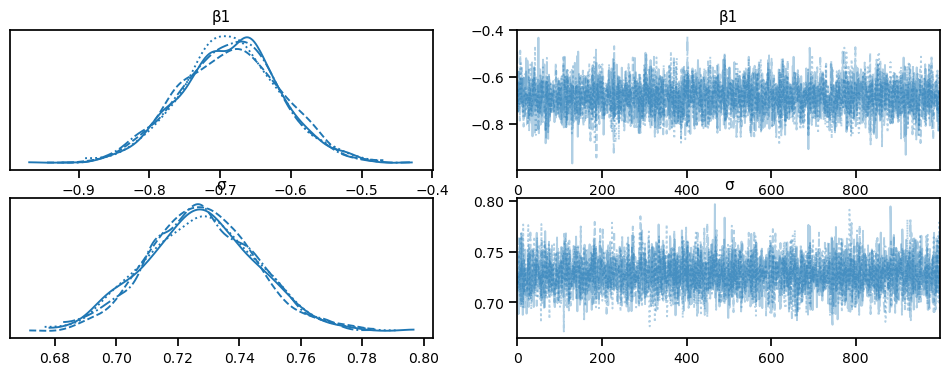

In [6]:
from arviz import plot_trace

plot_trace(trace_u, var_names=['β1', 'σ']);

### Hierarchical model

In [7]:
mn_counties = radon_data.county.unique()
counties = mn_counties.shape[0]
floor_measure = radon_data.floor.values
                             
with Model() as hierarchical_model:
    
    # Priors
    μ_b0 = Normal('μ_b0', mu=0., sigma=0.0001)
    σ_b0 = HalfCauchy('σ_b0', 5)
    
    
    # Random intercepts
    υ = Normal('υ', mu=0, sigma=1, shape=n_counties)
    β_0 = μ_b0 + υ * σ_b0
    # Common slope
    β_1 = Normal('β_1', mu=0., sigma=1e5)
    
    # Model error
    σ_y = HalfCauchy('σ_y', 5)
    
    # Expected value
    y_hat = β_0[county] + β_1 * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    
    trace_h = sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_b0, σ_b0, υ, β_1, σ_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Posterior predictive checks are basically equivalent among different models.. (what to conclude?)

Sampling: [y]


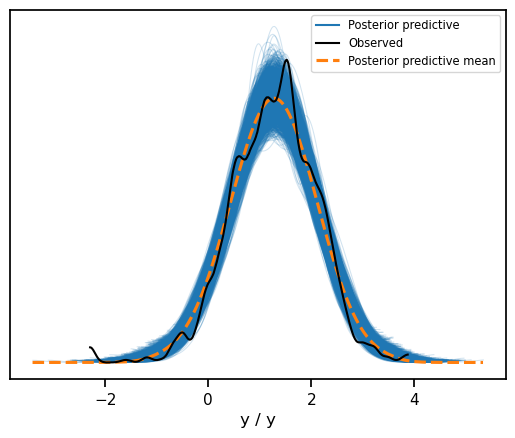

In [8]:
with pooled_model:
    ppc_p = pm.sample_posterior_predictive(trace_p)
    
az.plot_ppc(ppc_p);

Sampling: [y_like]


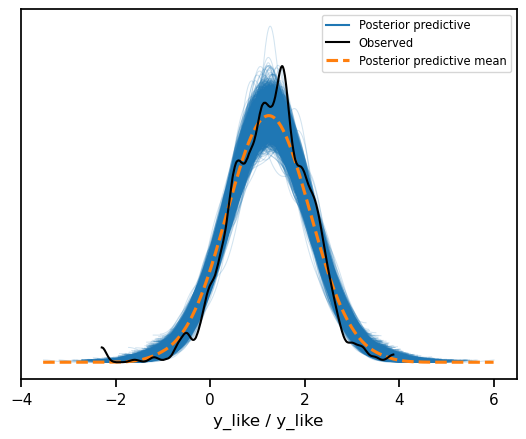

In [9]:
with hierarchical_model:
    #by default, 2000 draws of y
    #the returned dictionary (ppc) contains 2000 values of y sampled from the posterior of mu and sigma
    ppc_h = pm.sample_posterior_predictive(trace_h)
    
az.plot_ppc(ppc_h);

## Predictive Information Criteria

Measures of predictive accuracy are called **information criteria**, and are comprised of the log-predictive density of the data given a point estimate of the fitted model multiplied by −2 (i.e. the *deviance*):

$$−2 \log[p(y | \hat{\theta})]$$


The deviance is a measure of how well the model fits the data.

As you might expect, the expected accuracy of a fitted model’s predictions of future data will generally be lower than the accuracy of the model’s predictions for observed data, even though the parameters in the model happen to be sampled from the specified prior distribution.

Why are we interested in prediction accuracy?

1. to quantify the performance of a model
2. to perform model selection 

By model selection, we may not necessarily want to choose one model over another, but we might want to put different models on the same scale. The advantage if information-theoretic measures is that candidate models do not need to be nested; even models with completely different parameterizations can be used to predict the same measurements.

Note that when candidate models have the same number of parameters, one can compare their best-fit log predictive densities directly, but when model dimensions differ, one has to make an adjustment for the tendency of a *larger model to fit data better*.

One advantage of using predictive information criteria for model comparison is that they allow us to estimate **out-of-sample predictive accuracy** using the data in our sample. All such methods are *approximations* of predictive accuracy, so they are not perfect, but they perform reasonably well.

One can naively use the log predictive density for the sample data (within-sample predictive accuracy) as an approximation of the out-of-sample predictive accuracy, but this will almost always result in an overestimate of performance.

As is popular in machine learning, **cross-validation** can be used to evaluate predictive accuracy, whereby the dataset is partitioned and each partition is allowed to be used to fit the model and evaluate the fit. However, this method is computationally expensive because it reqiures the same model to be fit to multiple subsets of the data.

We will focus here on **adjusted within-sample predictive accuracy**, using a variety of information criteria. The goal here is to get an approximately unbiased estimate of predictive accuracy which are correct in expectation.

### AIC and DIC

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. **Akaike's Information Criterion (AIC)** is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias.

$$\text{AIC} = \underbrace{ −2 \log[p(y | \hat{\theta})]}_{\text{deviance}}+ \underbrace{2K}_{\text{penalization}}$$

AIC balances the **fit of the model** (in terms of the likelihood) with the **number of parameters** $K$. required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

AIC is  not Bayesian, as it relies on a **point estimate** of the model rather than using the full posterior.

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the **log pointwise posterior predictive density (LPPD)** and correcting for the effective number of parameters to adjust for overfitting.

The computed log pointwise predictive density is:

$$lppd_{comp} = \sum_{i=1}^N \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)}) \right)$$

The complexity adjustment here is as follows:

$$p_{WAIC} = 2\sum_{i=1}^N \left[ \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)})\right)  - \frac{1}{M} \sum_{j=1}^M \log p(y_i | \theta^{(j)})  \right]$$

so WAIC is then:

$$\text{WAIC} = -2(lppd) + 2p_{WAIC}$$

The adjustment is an approximation to the **number of unconstrained parameters** in the model (0=fully constrained, 1=no constraints). In this sense, WAIC treats the effective number of paramters as a random variable.

WAIC *averages* over the posterior distribution, and therefore is more reliable for a wider range of models.


### WAIC in depth

Both terms of WAIC look very similar.

 The first one, the lppd (log point-wise predictive density), is computing the mean likelihood over the  posterior samples. We do this for each data point and then we take the logarithm and sum up over all data points. 
 
This is the deviance but computed for each  posterior sample. 

As we already said, the lddp of observed data   is an overestimate of the lppd for future data. Thus, we introduce a second term to correct the overestimation; it computes the variance of the log-likelihood over the   posterior samples. We do this for each data point and then we sum up over all data points. 

Why does the variance give a penalization term? Well, the intuition is similar to that of the Bayes factor's built-in Occam's Razor. The larger the number of effective parameters, the greater the spread of the posterior will be. 

When we add structure to a model such as with informative/regularizing priors or hierarchical dependencies, we are restricting the posterior and thus decreasing the effective number of parameters in comparison with a similar unregularized or less structured model.

There are also Bayesian procedure of leave-one-out cross-validation, but we do not cover them here.

In [10]:
from arviz import waic

pooled_waic = waic(trace_p, pooled_model)
    
pooled_waic

Computed from 4000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1089.79    25.02
p_waic        3.65        -

In [11]:
unpooled_waic = waic(trace_u, unpooled_model)
    
unpooled_waic

Computed from 4000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1058.76    28.32
p_waic       82.82        -

There has been a warning during the calculation. Please check the results.

In [12]:
hierarchical_waic = waic(trace_h, hierarchical_model)
    
hierarchical_waic

Computed from 4000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1057.41    28.05
p_waic       80.50        -

There has been a warning during the calculation. Please check the results.

PyMC3 includes two convenience functions to help compare WAIC for different models. The first of this functions is `compare`, this one computes WAIC (or LOO) from a set of traces and models and returns a DataFrame.

In [13]:
from arviz import compare

df_comp_WAIC = compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='waic', seed=RANDOM_SEED)
df_comp_WAIC

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-1057.406785,80.498064,0.000000,0.110614,28.050694,0.000000,True,log
unpooled,1,-1058.761700,82.820062,1.354915,0.593737,28.323645,2.005714,True,log
pooled,2,-1089.794814,3.647307,32.388029,0.295649,25.023882,14.261758,False,log


We have many columns so let's check one by one the meaning of them:

1. The first column is the **rank order** of the models; zero is best.

2. The second column contains the **values of WAIC**. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

3. The third column is the estimated **effective number of parameters**. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data.

4. The fourth column is the **difference between the value of WAIC for the top-ranked model and the value of WAIC for each model**. For this reason we will always get a value of 0 for the first model. 

5. The fifth column contains **model weights**. Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

6. The sixth column records the **standard error for the WAIC computations**. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

7. dSE is the **standard error of the difference** in IC between each model and the top-ranked model. It’s always 0 for the top-ranked model. 

8. The second-last column is a flag for **warnings**. A value of `True` indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution. For more details you can read this [paper](https://arxiv.org/abs/1507.04544).

9. The last column indicates the **scale** used for the information criterion.

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) of the examples in the book to PyMC3).